# Necessary Imports
* Necessary imports are made

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import kaleido

# Creating the data frame
* The data frame is created from the lichess_data.txt document that I downloaded from the Lichess app.
* Here, I used regex to extract information because the file had a complex structure.
* I hided my rival's usernames since they may not want to be known.
* Also, I did some preprocessing to make the data more usable in the future.

In [2]:
with open('lichess_data.txt', 'r') as file:
    data = file.read()
    
games = data.split("\n\n\n")

game_list = []

for game in games:
    data_and_moves = game.split("\n\n")
    if (len(data_and_moves) == 2):
        moves = data_and_moves[1]
    else:
        moves = "No moves found"
    event = re.search(r'\[Event "(.*?)"\]', game)
    white = re.search(r'\[White "(.*?)"\]', game)
    black = re.search(r'\[Black "(.*?)"\]', game)
    result = re.search(r'\[Result "(.*?)"\]', game)
    utc_date = re.search(r'\[UTCDate "(.*?)"\]', game)
    utc_time = re.search(r'\[UTCTime "(.*?)"\]', game)
    white_elo = re.search(r'\[WhiteElo "(.*?)"\]', game)
    black_elo = re.search(r'\[BlackElo "(.*?)"\]', game)
    white_rating_diff = re.search(r'\[WhiteRatingDiff "(.*?)"\]', game)
    black_rating_diff = re.search(r'\[BlackRatingDiff "(.*?)"\]', game)
    time_control = re.search(r'\[TimeControl "(.*?)"\]', game)
    eco = re.search(r'\[ECO "(.*?)"\]', game)
    opening = re.search(r'\[Opening "(.*?)"\]', game)
    termination = re.search(r'\[Termination "(.*?)"\]', game)


    if all((event, white, black, result, utc_date, utc_time, white_elo, black_elo, white_rating_diff,\
            black_rating_diff, time_control, eco, opening,termination)):
        result_str = result.group(1)
        if result_str == "1-0": #extracting win, lose draw situation from the result
            win = "Win"
        elif result_str == "0-1":
            win = "Lose"
        else:
            win = "Draw"
        white_name = white.group(1)
        black_name = black.group(1)
        if white_name != "baysthee": # hiding my rival's usernames since they may not want to be seen
            white_name = "*****"
            rival_elo = int(white_elo.group(1))
            my_elo = int(black_elo.group(1))
        if black_name != "baysthee":
            black_name = "*****"
            rival_elo = int(black_elo.group(1))
            my_elo = int(white_elo.group(1))
        game_dict = {
            'Event': event.group(1),
            'White': white_name,
            'Black': black_name,
            'Result': result.group(1),
            'Win?': win,
            'UTCDate': utc_date.group(1),
            'UTCTime': utc_time.group(1),
            'WhiteElo': white_elo.group(1),
            'BlackElo': black_elo.group(1),
            'WhiteRatingDifference': white_rating_diff.group(1),
            'BlackRatingDifference': black_rating_diff.group(1),
            'TimeControl': time_control.group(1),
            'ECO': eco.group(1),
            'Opening': opening.group(1),
            'Termination': termination.group(1),
            'Moves': moves,
            'Rival Elo': rival_elo,
            'My Elo': my_elo
        }
        game_list.append(game_dict)

df = pd.DataFrame(game_list)

df


,Event,White,Black,Result,Win?,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDifference,BlackRatingDifference,TimeControl,ECO,Opening,Termination,Moves,Rival Elo,My Elo
0,Rated Blitz game,baysthee,*****,1-0,Win,2023.11.14,22:18:34,1459,1446,+6,-7,180+0,D00,Queen's Pawn Game: Accelerated London System,Normal,1. d4 d5 2. Bf4 Bf5 3. Nf3 Nf6 4. e3 e6 5. Bd3...,1446,1459
1,Rated Blitz game,*****,baysthee,0-1,Lose,2023.11.14,22:12:10,1460,1454,-6,+5,180+0,C46,Three Knights Opening,Normal,1. e4 e5 2. Nf3 Nc6 3. Nc3 Bc5 4. Bc4 d6 5. h3...,1460,1454
2,Rated Blitz game,baysthee,*****,0-1,Lose,2023.11.14,20:47:48,1460,1429,-6,+6,180+0,A40,Horwitz Defense,Time forfeit,1. d4 e6 2. Nc3 c5 3. dxc5 Bxc5 4. Nf3 Nf6 5. ...,1429,1460
3,Rated Blitz game,baysthee,*****,1-0,Win,2023.11.14,20:43:52,1454,1446,+6,-6,180+0,A40,English Defense,Normal,1. d4 b6 2. Nf3 Bb7 3. Bf4 e6 4. e3 Bb4+ 5. Nc...,1446,1454
4,Rated Blitz game,*****,baysthee,1-0,Win,2023.11.14,14:21:08,1405,1461,+7,-7,180+0,A00,Hungarian Opening,Time forfeit,1. g3 d5 2. Bg2 Nf6 3. b3 1-0,1405,1461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,Rated Blitz game,baysthee,*****,0-1,Lose,2021.12.24,22:02:20,1337,1381,-62,+4,180+0,A40,Englund Gambit,Normal,1. d4 e5 2. dxe5 Bc5 3. Bf4 Qh4 4. Bg3 Qb4+ 5....,1381,1337
2276,Rated Blitz game,*****,baysthee,0-1,Lose,2021.12.23,16:32:59,1158,1276,-4,+61,180+0,D02,Queen's Pawn Game: Anti-Torre,Normal,1. d4 d5 2. Nf3 Bg4 3. h3 Nf6 4. e3 Bxf3 5. Qx...,1158,1276
2277,Rated Blitz game,baysthee,*****,1-0,Win,2021.12.23,16:22:01,1188,1100,+88,-4,180+0,A40,Englund Gambit Complex: Mosquito Gambit,Normal,1. d4 e5 2. dxe5 Qh4 3. e3 Nc6 4. Nf3 Qe4 5. N...,1100,1188
2278,Rated Blitz game,*****,baysthee,1-0,Win,2021.12.23,16:14:03,1329,1375,+5,-187,180+0,C50,"Italian Game: Giuoco Pianissimo, Normal",Time forfeit,1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. d3 Nf6 5. Ng...,1329,1375


# Number Of Games Played by Month
* In this graph I constructed a histogram to show the number of games I played by months for each year.
* 2021 occurs in only December since I downloaded the app during that time.
* As it can be seen, I stopped playing in the middle of 2022.

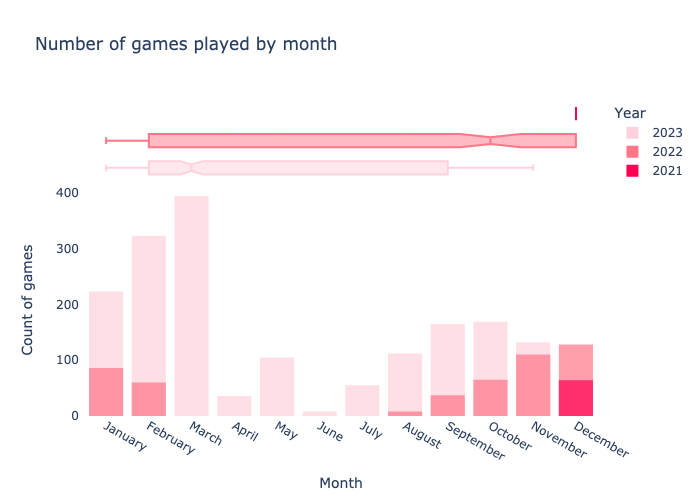

In [4]:
df['UTCDate'] = pd.to_datetime(df['UTCDate'])
df['UTCTime'] = pd.to_datetime(df['UTCTime'], format='%H:%M:%S')

pinkish_colors = ['#FFD1DC', '#FF7688', '#FF0055',]

import plotly.express as px
df['Year'] = df['UTCDate'].dt.year
df['Month'] = df['UTCDate'].dt.month_name()

fig = px.histogram(df, x="Month", color="Year", marginal="box",
                   opacity=0.7,color_discrete_sequence=pinkish_colors,
                   barmode='overlay', 
                   category_orders={'Month': ['January', 'February', 'March', 'April', 'May', 'June',
                                               'July', 'August', 'September', 'October', 'November', 'December']}, title = "Number of games played by month")

fig.update_layout(
    yaxis=dict(title='Count of games'),
    xaxis=dict(title='Month'),
    plot_bgcolor='rgba(255, 255, 255, 0.8)',  
    paper_bgcolor='rgba(255, 255, 255, 0.8)')
fig.show(renderer = "png", engine = 'orca')

# Games played by the time of day
* Constructed a histogram to highlight the number of games I played by the time of day.

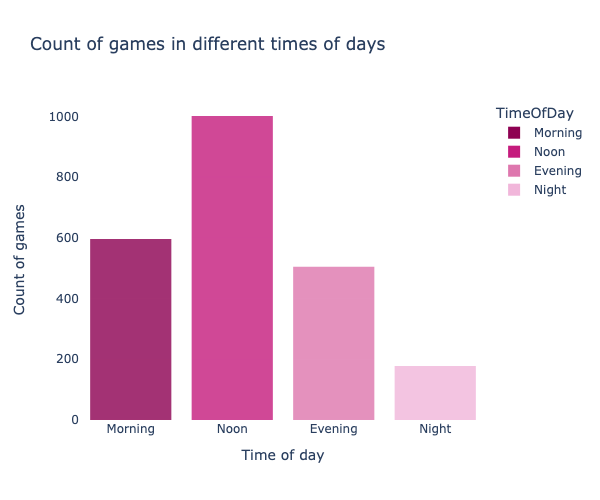

In [5]:
conds1 = [((df["UTCTime"].dt.hour < 12)& (df["UTCTime"].dt.hour >= 5)),\
         ((df["UTCTime"].dt.hour >= 12  )& (df["UTCTime"].dt.hour <= 17)),\
         ((df["UTCTime"].dt.hour > 17) & (df["UTCTime"].dt.hour <= 21)), \
         ((df["UTCTime"].dt.hour > 21) | (df["UTCTime"].dt.hour < 5))]
outcomes1 = ["Morning", "Noon", "Evening", "Night"]
df["TimeOfDay"] = np.select(conds1,outcomes1)
chess_times_df = df["TimeOfDay"]

piyg_colors = px.colors.diverging.PiYG
fig = px.histogram(chess_times_df, x="TimeOfDay",
                   opacity=0.8,
                   color= "TimeOfDay",
                   color_discrete_sequence=piyg_colors,  
                   category_orders={'TimeOfDay': ["Morning", "Noon", "Evening", "Night"]},
                   title="Count of games in different times of days")

fig.update_traces(marker=dict(line=dict(width=0)))

fig.update_layout(width=600, height=500)
fig.update_layout(
    yaxis=dict(title='Count of games'),
    xaxis=dict(title='Time of day'),
    plot_bgcolor='rgba(255, 255, 255, 0.8)', 
    paper_bgcolor='rgba(255, 255, 255, 0.8)')

fig.show(renderer = "png", engine = 'orca')

# Rate of winning according to time of the day
* I calculated the ratio of games won over total games by the time of the day I played the game.
* It seems like there is no significant evidence that the time I play the game effects my chance of winning.

In [42]:
mor_games= df[df["TimeOfDay"]== "Morning"]
mor_won_games= mor_games[mor_games["Win?"] == "Win"]
print("Morning: ", len(mor_won_games)/len(mor_games))
noon_games= df[df["TimeOfDay"]== "Noon"]
noon_won_games= noon_games[noon_games["Win?"] == "Win"]
print("Noon: ", len(noon_won_games)/len(noon_games))
ev_games= df[df["TimeOfDay"]== "Evening"]
ev_won_games= ev_games[ev_games["Win?"] == "Win"]
print("Evening: ", len(ev_won_games)/len(ev_games))
night_games= df[df["TimeOfDay"]== "Night"]
night_won_games= night_games[night_games["Win?"] == "Win"]
print("Night: ", len(night_won_games)/len(night_games))

Morning:  0.4899328859060403
Noon:  0.4835164835164835
Evening:  0.5128712871287129
Night:  0.5337078651685393


# Longest win, lose, draw streak

In [7]:
outcomes = list(df["Win?"])
outcomes_str = ''.join(['W' if outcome == 'Win' else 'X' for outcome in outcomes])
streaks = outcomes_str.split('X')
longest_win_streak = max(map(len, streaks))
print("Longest win streak is: ", longest_win_streak)

Longest win streak is:  10


In [8]:
outcomes = list(df["Win?"])
outcomes_str = ''.join(['L' if outcome == 'Lose' else 'X' for outcome in outcomes])

streaks = outcomes_str.split('X')

longest_lost_streak = max(map(len, streaks))
print("Longest lose streak is: ",longest_lost_streak)

Longest lose streak is:  9


In [9]:
outcomes = list(df["Win?"])
outcomes_str = ''.join(['D' if outcome == 'Draw' else 'X' for outcome in outcomes])

streaks = outcomes_str.split('X')

longest_draw_streak = max(map(len, streaks))
print("Longest draw streak is: ", longest_draw_streak)

Longest draw streak is:  3


# Visualization of streaks
* I used horizontal bar chart for visualization of the streaks.
* My win and lose streaks are closer, but draw streak is a little bit less.

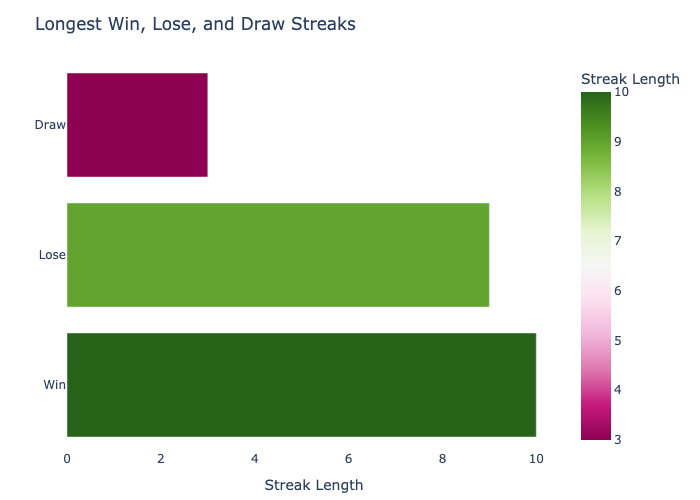

In [10]:
streaks_data = {'Type': ['Win', 'Lose', 'Draw'],
                'Streak_Length': [longest_win_streak, longest_lost_streak, longest_draw_streak]}
streaks_df = pd.DataFrame(streaks_data)
import plotly.express as px

fig = px.bar(streaks_df, x='Streak_Length', y='Type',
             color='Streak_Length',
             color_continuous_scale='PiYG', 
             labels={'Type': 'Streak Type', 'Streak_Length': 'Streak Length'},
             title='Longest Win, Lose, and Draw Streaks')

fig.update_layout(
    yaxis=dict(title=''),
    xaxis=dict(title='Streak Length'),
    coloraxis_colorbar=dict(title='Streak Length'),
    showlegend=False, 
    plot_bgcolor='rgba(255, 255, 255, 0.8)', 
    paper_bgcolor='rgba(255, 255, 255, 0.8)')

fig.update_layout(margin=dict(l=10, r=10, t=60, b=10))

fig.show(renderer = "png", engine = 'orca')

# Winning rates based on the role (white / black)

In [47]:
print("For White:")
role_white_df = df[df["White"] == "baysthee"]
role_white_win_df = role_white_df[role_white_df["Win?"] == "Win"]
print("Win: ", len(role_white_win_df)/len(role_white_df))
role_white_lose_df = role_white_df[role_white_df["Win?"] == "Lose"]
print("Lose: ", len(role_white_lose_df)/len(role_white_df))
role_white_draw_df = role_white_df[role_white_df["Win?"] == "Draw"]
print("Draw: ", len(role_white_draw_df)/len(role_white_df))

For White:
Win:  0.5017574692442882
Lose:  0.4446397188049209
Draw:  0.05360281195079086


In [48]:
print("For Black:")
role_black_df = df[df["Black"] == "baysthee"]
role_black_win_df = role_black_df[role_black_df["Win?"] == "Win"]
print("Win: ", len(role_black_win_df)/len(role_black_df))
role_black_lose_df = role_black_df[role_black_df["Win?"] == "Lose"]
print("Lose: ", len(role_black_lose_df)/len(role_black_df))
role_black_draw_df = role_black_df[role_black_df["Win?"] == "Draw"]
print("Draw: ", len(role_black_draw_df)/len(role_black_df))

For Black:
Win:  0.489492119089317
Lose:  0.4500875656742557
Draw:  0.06042031523642732


# Number of games played by days
* Again, constructed a histogram based on the days the games are played.
* There is no significant difference, yet Sunday is lower.

Text(0.5, 1.0, 'Count of games in different days')

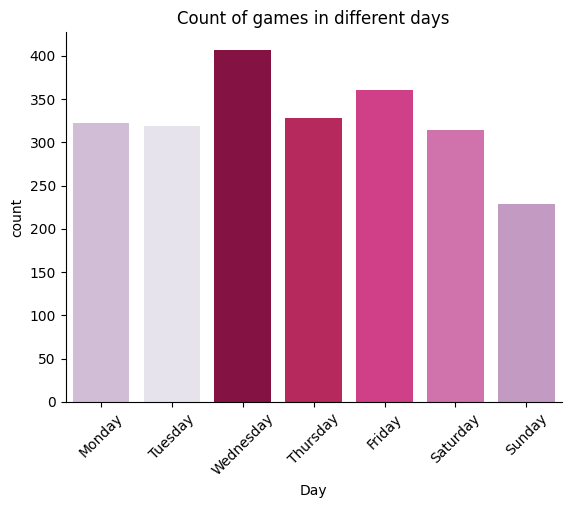

In [49]:
df_with_days = df
df_with_days["UTCDate"] = pd.to_datetime(df_with_days["UTCDate"])
conds_d = [(df["UTCDate"].dt.strftime("%A") == "Monday"),(df["UTCDate"].dt.strftime("%A") == "Tuesday"),\
         (df["UTCDate"].dt.strftime("%A") == "Wednesday"),(df["UTCDate"].dt.strftime("%A") == "Thursday"),\
         (df["UTCDate"].dt.strftime("%A") == "Friday"),(df["UTCDate"].dt.strftime("%A") == "Saturday"), (df["UTCDate"].dt.strftime("%A") == "Sunday")]
outcomes_d = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_with_days["Day"] = np.select(conds_d,outcomes_d,default="Other")
sns.countplot(x = "Day", data=df_with_days, palette = "PuRd", hue = "Day", legend = False, order = outcomes_d)  
plt.xticks(rotation = 45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("Count of games in different days")

# Winning rate according to the day the game is played
* I wanted to see if my chance of winning differs a lot by day.
* It seems that the day solely does not really affect my winning rate because numbers are mostly close.
* I did not even try to test this hypothesis since they are REALLY close.

In [50]:
monday_games= df_with_days[df_with_days["Day"]== "Monday" ]
monday_won_games= monday_games[monday_games["Win?"] == "Win"]
print("Monday: ", len(monday_won_games)/len(monday_games))
tuesday_games= df_with_days[df_with_days["Day"]== "Tuesday"]
tuesday_won_games= tuesday_games[tuesday_games["Win?"] == "Win"]
print("Tuesday: ",len(tuesday_won_games)/len(tuesday_games))
wednesday_games= df_with_days[df_with_days["Day"]== "Wednesday"]
wednesday_won_games= wednesday_games[wednesday_games["Win?"] == "Win"]
print("Wednesday: ",len(wednesday_won_games)/len(wednesday_games))
thursday_games= df_with_days[df_with_days["Day"]== "Thursday"]
thursday_won_games= thursday_games[thursday_games["Win?"] == "Win"]
print("Thursday: ",len(thursday_won_games)/len(thursday_games))
friday_games= df_with_days[df_with_days["Day"]== "Friday"]
friday_won_games= friday_games[friday_games["Win?"] == "Win"]
print("Friday: ",len(friday_won_games)/len(friday_games))
saturday_games= df_with_days[df_with_days["Day"]== "Saturday"]
saturday_won_games= saturday_games[saturday_games["Win?"] == "Win"]
print("Saturday: ",len(saturday_won_games)/len(saturday_games))
sunday_games= df_with_days[df_with_days["Day"]== "Sunday"]
sunday_won_games= sunday_games[sunday_games["Win?"] == "Win"]
print("Sunday: ",len(sunday_won_games)/len(sunday_games))

Monday:  0.45652173913043476
Tuesday:  0.4890282131661442
Wednesday:  0.4643734643734644
Thursday:  0.5091463414634146
Friday:  0.518005540166205
Saturday:  0.5318471337579618
Sunday:  0.5109170305676856


# Distribution of my Rival's Elos based on my win, lose and draw
* A histogram of my Rivals Elos based on my win, lose and draw is created.
* For this I sorted the values according to my Rivals' Elos and created a histogram using plotly express.
* The categories are win, lose and draw and can be seen overlayed in the histogram.
* The distributions seem to be close to normal, especially win and lose.

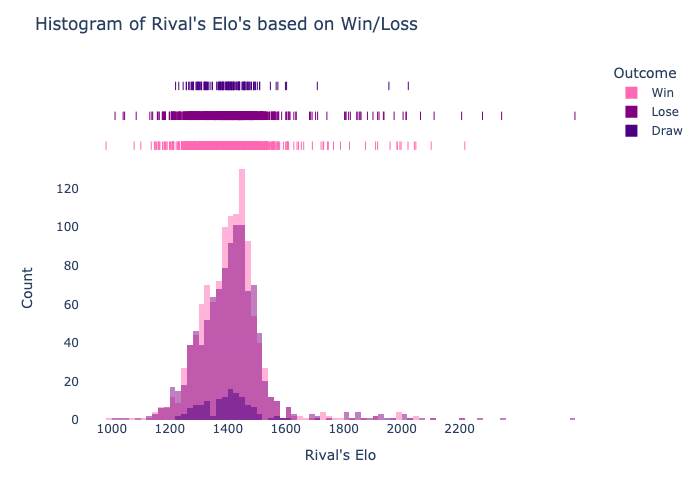

In [11]:
sorted_df = df.sort_values(by="Rival Elo")

fig = px.histogram(sorted_df, x="Rival Elo", color="Win?",
                   marginal="rug",
                   barmode="overlay",
                   nbins=150, 
                   histnorm="", 
                   labels={"Rival Elo": "Rival's Elo", "Win?": "Outcome"},
                   category_orders={"Win?": ["Win", "Lose", "Draw"]},
                   color_discrete_map={"Win": "#FF69B4", "Lose": "#800080", "Draw": "#4B0082"})

fig.update_layout(
    title="Histogram of Rival's Elo's based on Win/Loss",
    xaxis_title="Rival's Elo",
    yaxis_title="Count",
    xaxis=dict(tickmode='array', tickvals=np.arange(1000, 2201, 200)),
    bargap=0,  
    plot_bgcolor='rgba(255, 255, 255, 0.8)', 
    paper_bgcolor='rgba(255, 255, 255, 0.8)')

fig.show(renderer = "png", engine = 'orca')


# My Elo vs Rival Elo in games
* I wanted to plot my Elo vs my rival's Elo as a isomorphic heatmap to observe how the game is matching the players.
* As it is intutional, I get paired mostly with the rivals that have similar Elo to me.
* The most dense part seems to be nearly 1400 vs 1400.

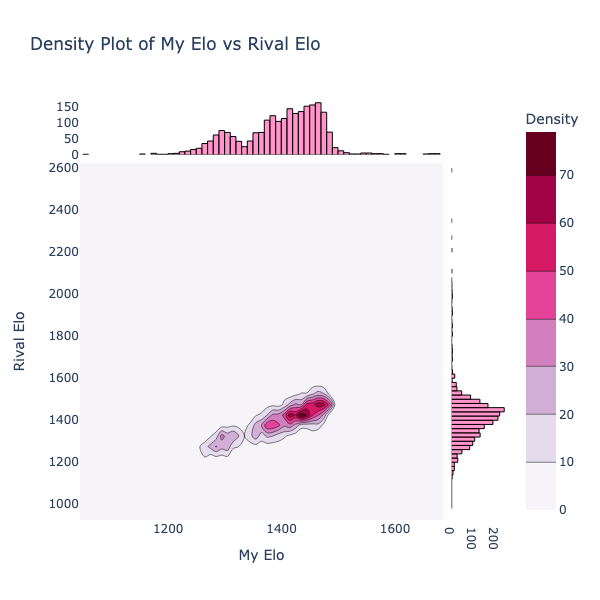

In [12]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Histogram2dContour(
    x=df["My Elo"],
    y=df["Rival Elo"],
    colorscale="PuRd", 
    nbinsx=70,  
    nbinsy=70,
    colorbar=dict(title='Density'),
    customdata=df,  
    hovertemplate='My Elo: %{x}<br>Rival Elo: %{y}<br>Density: %{z}<extra></extra>'))

fig.add_trace(go.Histogram(x=df["My Elo"], nbinsx=100, marker=dict(color='rgba(255, 105, 180, 0.7)', line=dict(color='black', width=1)), yaxis='y2',showlegend=False))

fig.add_trace(go.Histogram(y=df["Rival Elo"], nbinsy=100, marker=dict(color='rgba(255, 105, 180, 0.7)', line=dict(color='black', width=1)), xaxis='x2',showlegend=False))


fig.update_layout(
    xaxis_title='My Elo',
    yaxis_title='Rival Elo',
    title='Density Plot of My Elo vs Rival Elo',
    xaxis=dict(domain=[0, 0.85], title='My Elo'),
    yaxis=dict(domain=[0, 0.85], title='Rival Elo'),
    xaxis2=dict(domain=[0.87, 1], showgrid=False, gridcolor='white'),
    yaxis2=dict(domain=[0.87, 1], showgrid=False, gridcolor='white'),
    width=600,  
    height=600, 
    plot_bgcolor='white')

# Show the plot
fig.show(renderer = "png", engine = 'orca')


# Castling
* Another dataframe with castling information is created.
* The castling information is extracted from the "Moves" column.
* O-O-O means Queenside castling, O-O means Kingside castling, O-O O-O-O or O-O-O O-O means the rivals did castling right after each other.

In [13]:
castling_df = df
castling_list = []
for idx in castling_df.index:
    game_moves = castling_df["Moves"][idx]
    moves_list = []
    while (game_moves.find(".") != -1):
        moves = game_moves[game_moves.find(".")+1: game_moves.find(".", game_moves.find(".")+1)]
        moves_list.append(moves)
        game_moves = game_moves[game_moves.find(".")+1:]
    starting_idx = 0;
    if castling_df["Black"][idx] == "baysthee":
        starting_idx = 1
    castling_found = False;
    while (starting_idx < len(moves_list)):
        if ("O-O O-O-O" in moves_list[starting_idx]):
            castling_list.append("Kingside")
            castling_found = True;
            break;
        elif ("O-O-O O-O" in moves_list[starting_idx]):
            castling_list.append("Queenside")
            castling_found = True;
            break;
        elif ("O-O-O" in moves_list[starting_idx]):
            castling_list.append("Queenside")
            castling_found = True;
            break;
        elif ("O-O" in moves_list[starting_idx]):
            castling_list.append("Kingside")
            castling_found = True;   
            break;
        starting_idx += 2;
    if (castling_found == False):
        castling_list.append("None")
castling_df["Castling"] = castling_list
castling_df

,Event,White,Black,Result,Win?,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDifference,...,ECO,Opening,Termination,Moves,Rival Elo,My Elo,Year,Month,TimeOfDay,Castling
0,Rated Blitz game,baysthee,*****,1-0,Win,2023-11-14,1900-01-01 22:18:34,1459,1446,+6,...,D00,Queen's Pawn Game: Accelerated London System,Normal,1. d4 d5 2. Bf4 Bf5 3. Nf3 Nf6 4. e3 e6 5. Bd3...,1446,1459,2023,November,Night,Kingside
1,Rated Blitz game,*****,baysthee,0-1,Lose,2023-11-14,1900-01-01 22:12:10,1460,1454,-6,...,C46,Three Knights Opening,Normal,1. e4 e5 2. Nf3 Nc6 3. Nc3 Bc5 4. Bc4 d6 5. h3...,1460,1454,2023,November,Night,None
2,Rated Blitz game,baysthee,*****,0-1,Lose,2023-11-14,1900-01-01 20:47:48,1460,1429,-6,...,A40,Horwitz Defense,Time forfeit,1. d4 e6 2. Nc3 c5 3. dxc5 Bxc5 4. Nf3 Nf6 5. ...,1429,1460,2023,November,Evening,Kingside
3,Rated Blitz game,baysthee,*****,1-0,Win,2023-11-14,1900-01-01 20:43:52,1454,1446,+6,...,A40,English Defense,Normal,1. d4 b6 2. Nf3 Bb7 3. Bf4 e6 4. e3 Bb4+ 5. Nc...,1446,1454,2023,November,Evening,Queenside
4,Rated Blitz game,*****,baysthee,1-0,Win,2023-11-14,1900-01-01 14:21:08,1405,1461,+7,...,A00,Hungarian Opening,Time forfeit,1. g3 d5 2. Bg2 Nf6 3. b3 1-0,1405,1461,2023,November,Noon,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,Rated Blitz game,baysthee,*****,0-1,Lose,2021-12-24,1900-01-01 22:02:20,1337,1381,-62,...,A40,Englund Gambit,Normal,1. d4 e5 2. dxe5 Bc5 3. Bf4 Qh4 4. Bg3 Qb4+ 5....,1381,1337,2021,December,Night,None
2276,Rated Blitz game,*****,baysthee,0-1,Lose,2021-12-23,1900-01-01 16:32:59,1158,1276,-4,...,D02,Queen's Pawn Game: Anti-Torre,Normal,1. d4 d5 2. Nf3 Bg4 3. h3 Nf6 4. e3 Bxf3 5. Qx...,1158,1276,2021,December,Noon,Kingside
2277,Rated Blitz game,baysthee,*****,1-0,Win,2021-12-23,1900-01-01 16:22:01,1188,1100,+88,...,A40,Englund Gambit Complex: Mosquito Gambit,Normal,1. d4 e5 2. dxe5 Qh4 3. e3 Nc6 4. Nf3 Qe4 5. N...,1100,1188,2021,December,Noon,Queenside
2278,Rated Blitz game,*****,baysthee,1-0,Win,2021-12-23,1900-01-01 16:14:03,1329,1375,+5,...,C50,"Italian Game: Giuoco Pianissimo, Normal",Time forfeit,1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. d3 Nf6 5. Ng...,1329,1375,2021,December,Noon,Kingside


# Win statistics by Castling type
* A contingency table with the information number of each result of the game, total games played and win rates for each castling is created.
* As it can be seen, the choice of castling does not seem to have an effect on winning rate.

In [14]:
castling_stats = df.groupby(['Castling', 'Win?']).size().unstack(fill_value=0)
castling_stats['Total'] = castling_stats.sum(axis=1)

castling_stats['Win Rate'] = (castling_stats['Win'] / castling_stats['Total'])

sorted_castling = castling_stats['Win Rate'].sort_values(ascending=False)
castling_stats

Win?,Draw,Lose,Win,Total,Win Rate
Castling,,,,,
Kingside,61,491,527,1079,0.488415
None,47,414,485,946,0.512685
Queenside,22,115,118,255,0.462745


# Horizontal bar chart to visualize the results of the contingency table

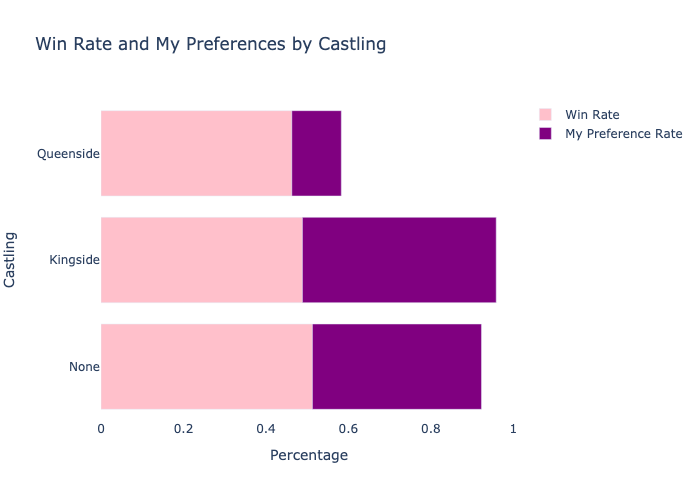

In [15]:

sorted_castling = castling_stats['Win Rate'].sort_values(ascending=False).reset_index()

your_preferences = {'Kingside': 0.47 , 'Queenside': 0.12, 'None': 0.41}  

win_rates_df = pd.DataFrame({'Win Rate': sorted_castling['Win Rate'], 'Castling': sorted_castling['Castling']})
preferences_df = pd.DataFrame(list(your_preferences.items()), columns=['Castling', 'My Preference Rate'])

combined_data = pd.merge(win_rates_df, preferences_df, on='Castling')

fig = px.bar(combined_data, x=['Win Rate', 'My Preference Rate'], y='Castling', orientation='h',
             title="Win Rate and My Preferences by Castling", template="plotly", color_discrete_sequence=['pink', 'purple'])


fig.update_layout(
    xaxis=dict(title='Percentage'),
    yaxis=dict(title='Castling'),
    legend=dict(title=None),
    showlegend=True,
    plot_bgcolor='rgba(255, 255, 255, 0.8)',
    paper_bgcolor='rgba(255, 255, 255, 0.8)', 
)

fig.show(renderer = "png", engine = 'orca')


# Outcome of the game by openings
* Here I created a contingency table based on openings. Counts of each outcome, total number of that opening is used and the win rate is present in the table.
* To be safe, I eliminated openings that I used less than 10 times.
* I also eliminated where my rivals have lower Elo than me to ensure that there is no advantage of experience.

In [17]:
#opening_stats_with_ranks = df.groupby(['Opening', 'Win?']).size().unstack(fill_value=0) 
opening_stats_with_win = df[['Opening', 'Win?']]
ranks = df[['Rival Elo', 'My Elo']]

#opening_stats_with_ranks['Total'] = opening_stats_with_ranks.sum(axis=1)
for idx in opening_stats_with_win.index: 
    if (ranks["My Elo"][idx] > ranks["Rival Elo"][idx] - 40):
        opening_stats_with_win = opening_stats_with_win.drop(index = idx)

opening_stats_with_ranks =  opening_stats_with_win.groupby(['Opening', 'Win?']).size().unstack(fill_value=0)  
opening_stats_with_ranks['Total'] = opening_stats_with_ranks.sum(axis = 1)

for idx in opening_stats_with_ranks.index: 
    if (opening_stats_with_ranks['Total'][idx] < 10):
        opening_stats_with_ranks = opening_stats_with_ranks.drop(index = idx)
opening_stats_with_ranks['Win Rate'] = (opening_stats_with_ranks['Win'] / opening_stats_with_ranks['Total'])
sorted_openings_r = opening_stats_with_ranks['Win Rate'].sort_values(ascending=False)

opening_stats_with_ranks

Win?,Draw,Lose,Win,Total,Win Rate
Opening,,,,,
Bishop's Opening: Boi Variation,0,5,6,11,0.545455
Englund Gambit,0,6,7,13,0.538462
Horwitz Defense,0,9,9,18,0.500000
Indian Defense: London System,0,8,5,13,0.384615
Italian Game: Classical Variation,1,4,5,10,0.500000
London System,0,7,3,10,0.300000
Queen's Pawn Game,2,13,12,27,0.444444
Queen's Pawn Game: Accelerated London System,1,22,31,54,0.574074
Queen's Pawn Game: London System,0,18,13,31,0.419355


# Z-Test for Proportions 
* Z-test for proportions is used to observe if an opening has significant chance of winning than other.
* Null hypotheses are opening does not affect the winning rate for each opening.
* The results are printed if the null hypothesis is rejected for a pair of openings.
* 0.05 significance level is used.

In [18]:
for i in range(11):
    for j in range(i+1, 11):
        nobs1 = int(opening_stats_with_ranks.loc[sorted_openings_r.index[i], "Total"])
        nobs2 = int(opening_stats_with_ranks.loc[sorted_openings_r.index[j], "Total"])
        count1 = int(opening_stats_with_ranks.loc[sorted_openings_r.index[i], "Win"])
        count2 = int(opening_stats_with_ranks.loc[sorted_openings_r.index[j], "Win"])
        z_score, pval = proportions_ztest([count1, count2], [nobs1, nobs2], alternative ="larger")
        if (pval < 0.05):
            print(f"Using {sorted_openings_r.index[i]} results in higher chance of winning than {sorted_openings_r.index[j]}")

Using Scandinavian Defense: Valencian Variation results in higher chance of winning than Queen's Pawn Game: London System
Using Scandinavian Defense: Valencian Variation results in higher chance of winning than Indian Defense: London System
Using Scandinavian Defense: Valencian Variation results in higher chance of winning than London System
Using Scandinavian Defense: Valencian Variation results in higher chance of winning than Queen's Pawn Game: Modern Defense
Using Queen's Pawn Game: Accelerated London System results in higher chance of winning than Queen's Pawn Game: Modern Defense
Using Bishop's Opening: Boi Variation results in higher chance of winning than Queen's Pawn Game: Modern Defense
Using Englund Gambit results in higher chance of winning than Queen's Pawn Game: Modern Defense
Using Horwitz Defense results in higher chance of winning than Queen's Pawn Game: Modern Defense
Using Italian Game: Classical Variation results in higher chance of winning than Queen's Pawn Game: M

# Visualization of the hypothesis test
* A network graph is used to visualize the results of the test.
* The nodes represent openings and win rates are also provided. If two nodes are connected, one has higher chance of winning than other one.
* It can be seen that Queen's Pawn Game: Modern Defense has the highest degree, and has smaller chance of winning than most of the openings present in the graph.

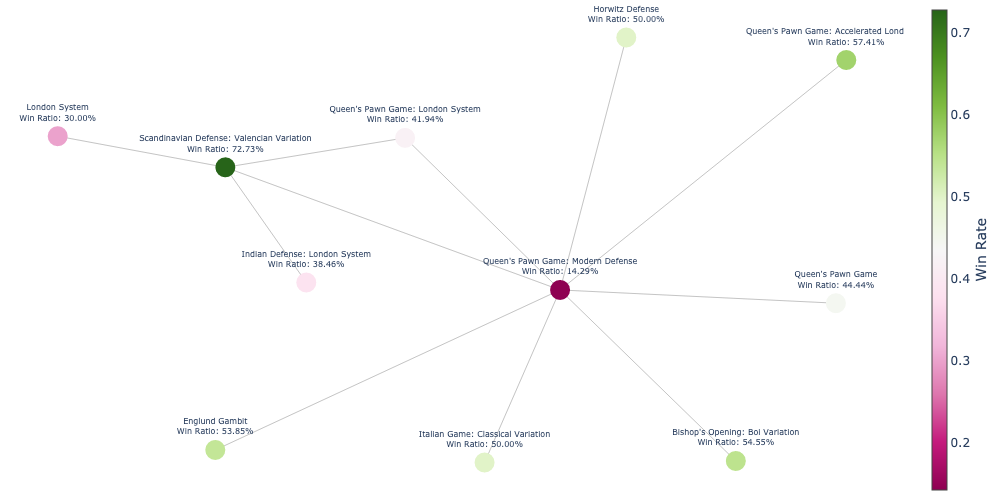

In [20]:

G = nx.Graph()

for i in range(11):
    G.add_node(sorted_openings_r.index[i])

for i in range(11):
    for j in range(i + 1, 11):
        nobs1 = int(opening_stats_with_ranks.loc[sorted_openings_r.index[i], "Total"])
        nobs2 = int(opening_stats_with_ranks.loc[sorted_openings_r.index[j], "Total"])
        count1 = int(opening_stats_with_ranks.loc[sorted_openings_r.index[i], "Win"])
        count2 = int(opening_stats_with_ranks.loc[sorted_openings_r.index[j], "Win"])
        z_score, pval = proportions_ztest([count1, count2], [nobs1, nobs2], alternative="larger")
        if pval < 0.05:
            G.add_edge(sorted_openings_r.index[i], sorted_openings_r.index[j], weight=pval)

pos = nx.spring_layout(G)

edge_x = []
edge_y = []
edge_text = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_text.append(f'p-value: {edge[2]["weight"]:.4f}')

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='text',
    text=edge_text,
    mode='lines')

node_trace = go.Scatter(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    text=[f'{node}<br>Win Ratio: {opening_stats_with_ranks.loc[node, "Win Rate"]:.2%}' for node in G.nodes()],
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='PiYG',
        size=20,  
        colorbar=dict(
            thickness=15,
            title='Win Rate',
            xanchor='left',
            titleside='right'
        )
    ),
    textposition="top center",
    textfont=dict(size=8)
)

node_trace.marker.color = [opening_stats_with_ranks.loc[node, "Win Rate"] for node in G.nodes()]

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=0),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    width= 1000,
                    height = 500,
                    plot_bgcolor='rgba(255, 255, 255, 0.8)', 
                    paper_bgcolor='rgba(255, 255, 255, 0.8)', 
                ))

fig.show(renderer = "png", engine = 'orca')


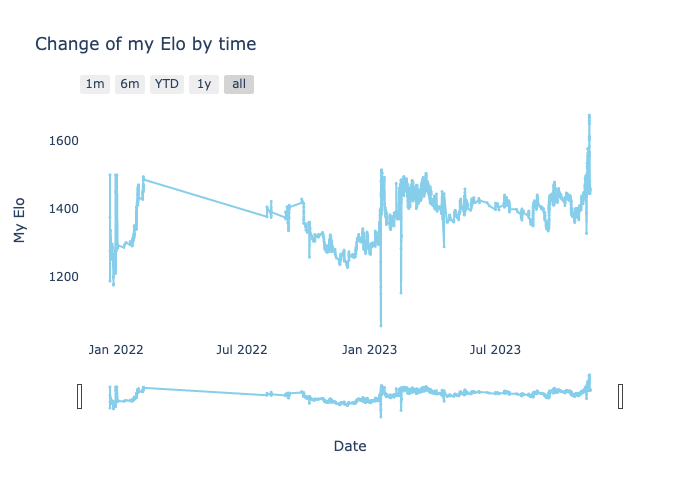

In [21]:
df['UTCDate'] = pd.to_datetime(df['UTCDate'])
elo_df = df.sort_values('UTCDate').groupby('UTCDate').last().reset_index()
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=list(df["UTCDate"]), y=list(df["My Elo"]),mode='lines+markers',  # Use 'markers' mode to display individual points
    marker=dict(
        color='skyblue', 
        size=3 
    ), hovertemplate='<br>'.join([
            'Rank: %{y}',
            'Date: %{x}']), name= ""))


fig.update_layout(
    title_text="Change of my Elo by time"
)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.update_xaxes(showspikes=True, spikecolor="purple", spikesnap="cursor", spikemode="across")
fig.update_yaxes(showspikes=True, spikecolor="orange", spikethickness=2)
fig.update_layout(spikedistance=1000, hoverdistance=100,
                 plot_bgcolor='rgba(255, 255, 255, 0.8)', 
                    paper_bgcolor='rgba(255, 255, 255, 0.8)',
                 xaxis=dict(title='Date'),
                yaxis=dict(title='My Elo'))

fig.show(renderer = "png", engine = 'orca')

# Win/Loss Distribution Against Varied Ratings
* A waffle chart is used to visualize the relative frequencies of outcomes based on my rivals ratings.

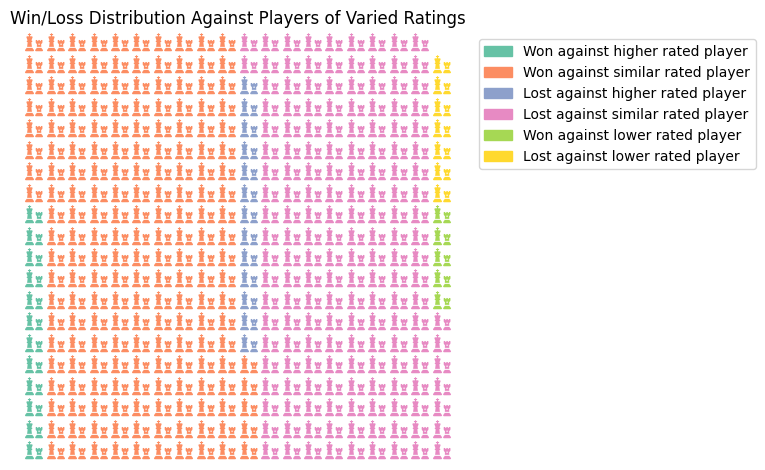

In [59]:
rank_win_df = df[["Rival Elo", "My Elo", "Win?"]].copy()
rank_dict = {"Won against higher rated player":0 ,"Won against similar rated player":0, "Lost against higher rated player":0,
            "Lost against similar rated player":0, "Won against lower rated player":0, "Lost against lower rated player":0}
for idx in rank_win_df.index:
    if (rank_win_df["Rival Elo"][idx] - 100 > rank_win_df["My Elo"][idx]) and (rank_win_df["Win?"][idx] == "Win"):
        rank_dict["Won against higher rated player"] += 1
    elif (abs(rank_win_df["Rival Elo"][idx] - rank_win_df["My Elo"][idx]) <= 100) and (rank_win_df["Win?"][idx] == "Win"):
        rank_dict["Won against similar rated player"] += 1
    elif (rank_win_df["Rival Elo"][idx] - 100 > rank_win_df["My Elo"][idx]) and (rank_win_df["Win?"][idx] == "Lose"):
        rank_dict["Lost against higher rated player"] += 1
    elif (abs(rank_win_df["Rival Elo"][idx] - rank_win_df["My Elo"][idx]) <= 100) and (rank_win_df["Win?"][idx] == "Lose"):
        rank_dict["Lost against similar rated player"] += 1
    elif (rank_win_df["Rival Elo"][idx] + 100 < rank_win_df["My Elo"][idx]) and (rank_win_df["Win?"][idx] == "Win"):
        rank_dict["Won against lower rated player"] += 1
    elif (rank_win_df["Rival Elo"][idx] + 100 < rank_win_df["My Elo"][idx]) and (rank_win_df["Win?"][idx] == "Lose"):
        rank_dict["Lost against lower rated player"] += 1

from pywaffle import Waffle

plt.figure(
  FigureClass=Waffle,
  rows=20,
  columns=20,
  icons= "chess",
  values=rank_dict,
  font_size=13,
  legend={'loc': 'upper left', 'bbox_to_anchor': (1.05, 1)},
)
plt.title("Win/Loss Distribution Against Players of Varied Ratings")
plt.show()

# Preprocessing the dataframe for Machine Learning model
* Outcomes of the games are mapped to 0, 1 and 2.
* To be safe, I only looked at games approximately longer than 10 moves.
* Also, I discarded the draw outcome since it has significantly smaller frequency than the other two.

In [60]:
win_map = {"Win": 0,
           "Lose": 1,
           "Draw": 2}

ml_df = df[["Win?", "Rival Elo", "My Elo", "Moves"]]

ml_df = ml_df[ml_df["Moves"].apply(len) > 120/2]
ml_df = ml_df.drop("Moves", axis = "columns")

ml_df["Win?"] = ml_df["Win?"].map(win_map)

ml_df = ml_df[ml_df['Win?'] != 2]

ml_df

,Win?,Rival Elo,My Elo
0,0,1446,1459
1,1,1460,1454
2,1,1429,1460
3,0,1446,1454
5,0,1410,1456
...,...,...,...
2275,1,1381,1337
2276,1,1158,1276
2277,0,1100,1188
2278,0,1329,1375


# Decision Tree Model to predict win/lose
* I shuffled the data and seperated my y as outcome and others as x.
* I used %80 of my data for train and %20 of my data to test.
* I used hyperparameter tuning and choose the best parameters to train my model GridSearchCV.
* The best parameters are printed.
* In the classification report, it can be seen that the model is more successful in class 0 (win).
* Confusion matrix is also printed.

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2}
Accuracy: 0.5781990521327014
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.85      0.68       225
           1       0.61      0.27      0.37       197

    accuracy                           0.58       422
   macro avg       0.59      0.56      0.53       422
weighted avg       0.59      0.58      0.54       422

Precision: 0.6091954022988506
AUC-ROC: 0.5589622109419063


Win?
0    225
1    197
Name: count, dtype: int64

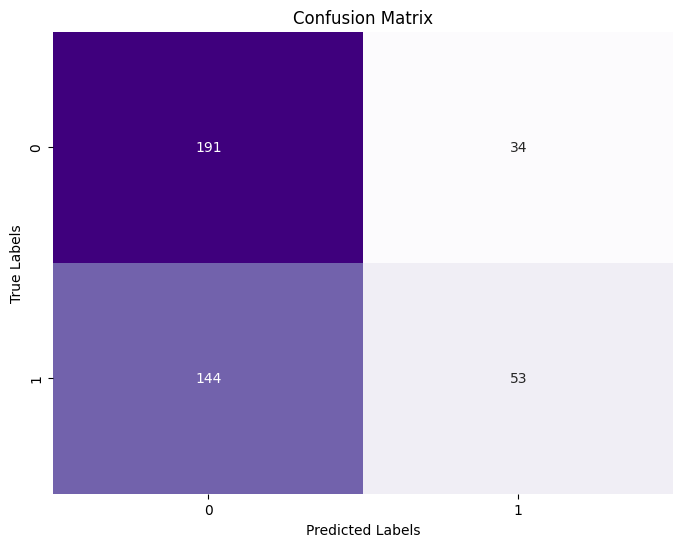

In [238]:
shuffled_df = ml_df.sample(frac=1).reset_index(drop=True)
y = shuffled_df["Win?"]
x = shuffled_df.drop("Win?", axis=1)

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid, cv=5, scoring="accuracy")
grid_search.fit(train_x, train_y)

best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

best_model = grid_search.best_estimator_

y_pred = best_model.predict(test_x)

accuracy = accuracy_score(test_y, y_pred)
classification_report_result = classification_report(test_y, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report_result)

precision = precision_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y, y_pred)

print(f'Precision: {precision}')
print(f'AUC-ROC: {roc_auc}')
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
test_y.value_counts()